# DiffEdit implementation notebook

This notebook shows a quick implementation of [DiffEdit: Diffusion-based semantic image editing with mask guidance](https://arxiv.org/abs/2210.11427) using the HuggingFace diffusers library.
This notebook is based on the [Stable Diffusion Deep Dive](https://github.com/fastai/diffusion-nbs/blob/master/Stable%20Diffusion%20Deep%20Dive.ipynb) notebook from FastAI. Please refer to it for more explanations.

## Setup & Imports

You'll need to log into huggingface and accept the terms of the licence for this model - see the [model card](https://huggingface.co/CompVis/stable-diffusion-v1-4) for details.

In [1]:
!pip install -q -U transformers diffusers ftfy accelerate

In [2]:
from base64 import b64encode

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

import matplotlib.animation as animation
from IPython.display import HTML

from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os

torch.manual_seed(1)
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if "mps" == torch_device: os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"

## Loading the models

In [3]:
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

## Encoding our image

Let's use the VAE to encode our image into a latent representation. The following 2 functions allow the conversion image RGB (3x512x512) <--> latent (4x64x64)

In [4]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch (so size 1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

Let's load and encode our image. Every parameters we will use later are all in the following cell so we can easily modify them from a single place.

In [5]:
image_name = "horse.jpg" #image to load

#parameters we will use later.
height = 512
width = 512
mask_inference_steps = 15
mask_noise_strength = 0.5

num_inference_steps = 50
encoding_ratio = 0.8

#prompts
source_prompt = "Photo of a horse"
destination_prompt = "Photo of a zebra"

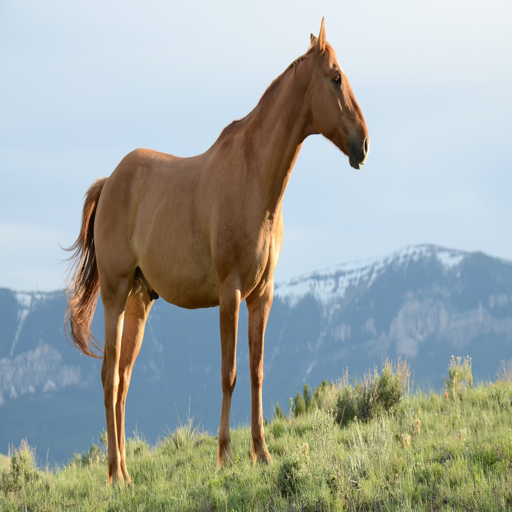

In [6]:
# Load the image with PIL
input_image = Image.open(image_name).resize((width, height))
input_image

We encode the image with the function we defined earlier

In [7]:
# Encode to the latent space
encoded = pil_to_latent(input_image)
encoded.shape

torch.Size([1, 4, 64, 64])

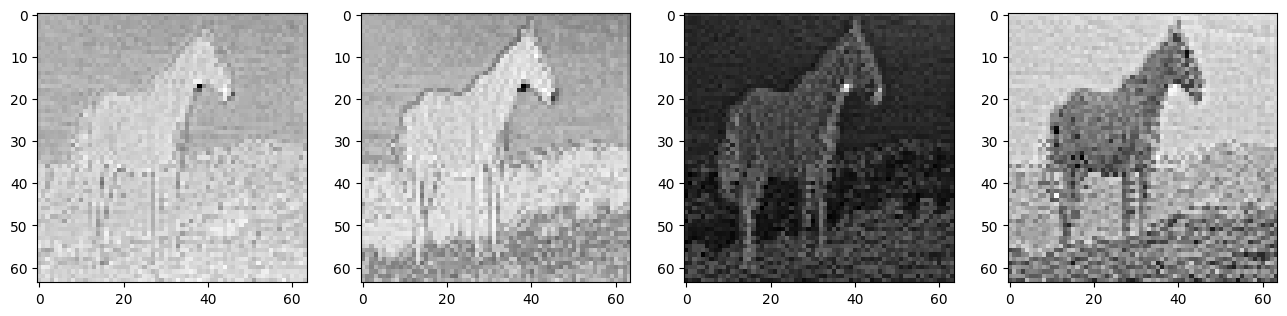

In [8]:
# Let's visualize the four channels of this latent representation:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(encoded[0][c].cpu(), cmap='Greys')

# Step 1: Compute Mask

The first step is to create a mask of the region we wish to modify.
The method described in the paper is quite simple. 
First we add noise to the latent representation. How much noise we add is controlled by the mask_noise_strength parameter defined in the cell containing all the parameters.

In [9]:
# The scheduler step we will use to add noise
noise_sampling_step = int(mask_inference_steps * mask_noise_strength)

# Prep Scheduler (setting the number of inference steps)
scheduler.set_timesteps(mask_inference_steps)

# Prep latents
noise = torch.randn_like(encoded)
latents = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([scheduler.timesteps[noise_sampling_step]]))

Then we denoise the image like a regular diffusion process. However we denoise the image using 2 prompts. A prompt describing our original image
(which we call the source prompt) and a prompt describing the image with the desired modification (the destination prompt). By substracting the noises we get from these prompts we get out mask.

In [10]:
prompt = [source_prompt, destination_prompt]

# Tokenizings the prompts
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]

In [11]:
latent_model_input = torch.cat([latents] * 2)
latent_model_input = scheduler.scale_model_input(latent_model_input, scheduler.timesteps[noise_sampling_step])
# predict the noise residual

with torch.no_grad():
        t = scheduler.timesteps[noise_sampling_step]
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]
        noise1, noise2 = noise_pred.chunk(2)
        # Creating the mask using the absolute difference from the 2 noises 
        mask = (noise1 - noise2).abs().mean(1) 

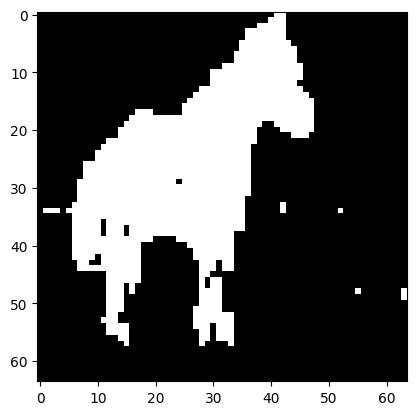

In [12]:
from torchvision import transforms
import matplotlib.pyplot as plt
import cv2 as cv

# Normalizing the mask values
mask_b = (mask - mask.mean((-1,-2)))/mask.std((-1,-2))
mask_b = mask_b.cpu().numpy()

#Applying blur to smooth the mask 
blur = cv.GaussianBlur(mask_b,(3,3),0)
mask_b = torch.tensor(blur*4).to(torch_device)

#Thresholding
mask_b = mask_b > 0.5
#plt.imshow(blur[0], cmap='gray')
plt.imshow(mask_b[0].detach().cpu(), cmap='gray')

Our mask is ready. Time for the next step in the diffedit process!

## Step 2: Encode

In this step we encode our input image at each timestep of our scheduler. We will use these latents in the following step.

In [13]:
# Prep Scheduler (setting the number of inference steps)
scheduler.set_timesteps(num_inference_steps)

# Prep latents (noising appropriately for start_step)
start_step = int(num_inference_steps*(1-encoding_ratio))
print(start_step)
start_sigma = scheduler.sigmas[start_step]

encoded = pil_to_latent(input_image)

noise = torch.randn_like(encoded)
st2_latents = scheduler.add_noise(encoded, noise, timesteps=torch.tensor(scheduler.timesteps[start_step:]))
st2_latents = st2_latents.to('cpu').float()
st2_latents.shape


9


/tmp/ipykernel_306/601586059.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  st2_latents = scheduler.add_noise(encoded, noise, timesteps=torch.tensor(scheduler.timesteps[start_step:]))


torch.Size([41, 4, 64, 64])

Let's take a look at what we have:

In [14]:
preview = st2_latents.mean(1)

interval = .2 #in seconds
frames = len(preview)

fig = plt.figure( figsize=(4,4))
im = plt.imshow(preview[0], cmap = 'cividis', vmin=0, vmax=1)
plt.close()

def animate_func(i):
    im.set_array(preview[i])
    return [im]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = frames,
                               interval = interval * 1000, # in ms
                               )
HTML(anim.to_jshtml())

## Step 3: Decoding with mask guidance

Final step in the diffedit methode: we do a standard diffusion process using only the destination prompt. The trick here is that at each step of the diffusion process we will replace all the values outside the mask by the values we saved during the previous step.

In [15]:
guidance_scale = 8   # Scale for classifier-free guidance

prompt = [destination_prompt]
# Prep text (same as before)
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""], padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

scheduler.set_timesteps(num_inference_steps)

# Prep latents
latents = st2_latents[0].to(torch_device)[None,:]

for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    if i >= start_step: # << This is the only modification to the loop we do
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample
        # Mask guidance
        if (i < len(scheduler.timesteps)-1):
            latents = mask_b * latents + (~mask_b)*st2_latents[i-start_step].to(torch_device)


  0%|          | 0/50 [00:00<?, ?it/s]

The before, after:

In [16]:
output_image = latents_to_pil(latents)[0]

fps = 1
nSeconds = 2
snapshots = [input_image, output_image]

fig = plt.figure( figsize=(8,8) )

a = snapshots[0]
im = plt.imshow(a, interpolation='bilinear', aspect='auto', vmin=0, vmax=1)
plt.axis('off')
plt.close()

def animate_func(i):
    if i < 0.5 * nSeconds*fps:
        im.set_array(snapshots[0])
    else:
        im.set_array(snapshots[1])
    return [im]

anim = animation.FuncAnimation(
                               fig, 
                               animate_func, 
                               frames = nSeconds * fps,
                               interval = 1000 / fps, # in ms
                               )
HTML(anim.to_jshtml())

# Full Code

The full code organized in a class for ease of use:

In [17]:
from base64 import b64encode

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login
import cv2 as cv

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os

torch.manual_seed(1)
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if "mps" == torch_device: os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"

In [18]:
class DiffEdit:
    
    # Todo: make it work with models other than stable-diffusion v1.4
    def __init__(self):
        # Load the autoencoder model which will be used to decode the latents into image space.
        self.vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

        # Load the tokenizer and text encoder to tokenize and encode the text.
        self.tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
        self.text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

        # The UNet model for generating the latents.
        self.unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

        # The noise scheduler
        self.scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

        # To the GPU we go!
        self.vae = self.vae.to(torch_device)
        self.text_encoder = self.text_encoder.to(torch_device)
        self.unet = self.unet.to(torch_device);

    def pil_to_latent(self,input_im):
        # Single image -> single latent in a batch (so size 1, 4, 64, 64)
        with torch.no_grad():
            latent = self.vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device)*2-1) # Note scaling
        return 0.18215 * latent.latent_dist.sample()

    def latents_to_pil(self,latents):
        # bath of latents -> list of images
        latents = (1 / 0.18215) * latents
        with torch.no_grad():
            image = self.vae.decode(latents).sample
        image = (image / 2 + 0.5).clamp(0, 1)
        image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
        images = (image * 255).round().astype("uint8")
        pil_images = [Image.fromarray(image) for image in images]
        return pil_images


    def compute_mask(self,
                     encoded_img,
                     src_prompt, 
                     dst_prompt, 
                     scheduler_steps, 
                     noise_strength = 0.5, 
                     n = 10, 
                     b_strength = 4):

        prompt = [src_prompt, dst_prompt]
        sampling_step = int(scheduler_steps * noise_strength)

        # Get text embeddings
        text_input = self.tokenizer(prompt, padding="max_length", max_length=self.tokenizer.model_max_length, truncation=True, return_tensors="pt")
        with torch.no_grad():
            text_embeddings = self.text_encoder(text_input.input_ids.to(torch_device))[0]

        # Initial mask
        mask = torch.zeros((1,64,64)).to('cuda')

        with torch.no_grad():

            # Repeat the process n times and average 
            for i in range(n):

                # Prep Scheduler (setting the number of inference steps)
                self.scheduler.set_timesteps(scheduler_steps)

                noise = torch.randn_like(encoded_img)
                # Adding noise to the encoded image to get our latents
                latents = self.scheduler.add_noise(encoded_img, noise, timesteps=torch.tensor([self.scheduler.timesteps[sampling_step]]))

                # Duplicating the latents as we will perform 2 diffusion steps in parallel, one for the src prompt and one for the dst prompt
                latent_model_input = torch.cat([latents] * 2)
                latent_model_input = self.scheduler.scale_model_input(latent_model_input, self.scheduler.timesteps[sampling_step])

                # predict the noise residual
                t = self.scheduler.timesteps[sampling_step]
                noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]
                noise_src, noise_dst = noise_pred.chunk(2)
                
            mask += (noise_src - noise_dst).abs().mean(1)
            
        mask /= n
        
        #Normalizing
        mask = (mask - mask.mean((-1,-2)))/mask.std((-1,-2))
        mask = mask.cpu().numpy()

        # Blur to smooth the mask
        blur = cv.GaussianBlur(mask,(3,3),0)    
        mask_b = torch.tensor(blur*b_strength).to(torch_device)

        # Threshold to create a binary mask
        mask_b = mask_b > 0.5

        return mask_b
    

    def compute_st2_latents(self,
                            encoded_img, 
                            scheduler_steps = 50, 
                            encoding_ratio = 0.6):

        # Prep Scheduler (setting the number of inference steps)
        self.scheduler.set_timesteps(scheduler_steps)

        # Prep latents (noising appropriately for start_step)
        start_step = int(scheduler_steps*(1-encoding_ratio))
        start_sigma = self.scheduler.sigmas[start_step]

        noise = torch.randn_like(encoded_img)
        st2_latents = self.scheduler.add_noise(encoded_img, noise, timesteps=torch.tensor(self.scheduler.timesteps[start_step:]))
        return st2_latents
    
    def decoding_with_mask_guidance(self,
                                    encoded_img, 
                                    mask, st2_latents, 
                                    destination_prompt,
                                    scheduler_steps=50, 
                                    encoding_ratio = 0.6,
                                    guidance_scale = 8):
        
        prompt = [destination_prompt]
        # Prep text (same as before)
        text_input = self.tokenizer(prompt, padding="max_length", max_length=self.tokenizer.model_max_length, truncation=True, return_tensors="pt")

        with torch.no_grad():
            text_embeddings = self.text_encoder(text_input.input_ids.to(torch_device))[0]

        max_length = text_input.input_ids.shape[-1]
        uncond_input = self.tokenizer(
            [""], padding="max_length", max_length=max_length, return_tensors="pt"
        )
        with torch.no_grad():
            uncond_embeddings = self.text_encoder(uncond_input.input_ids.to(torch_device))[0]
        text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

        self.scheduler.set_timesteps(scheduler_steps)

        # Prep latents
        start_step = int(scheduler_steps*(1-encoding_ratio))
        latents = st2_latents[0].to(torch_device)[None,:]

        for i, t in tqdm(enumerate(self.scheduler.timesteps), total=len(self.scheduler.timesteps)):
            if i >= start_step: # << This is the only modification to the loop we do
                # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
                latent_model_input = torch.cat([latents] * 2)
                sigma = self.scheduler.sigmas[i]
                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

                # predict the noise residual
                with torch.no_grad():
                    noise_pred = self.unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

                # perform guidance
                noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
                # compute the previous noisy sample x_t -> x_t-1
                latents = self.scheduler.step(noise_pred, t, latents).prev_sample
                if (i < len(self.scheduler.timesteps)-1):
                    latents = mask * latents + (~mask)*st2_latents[i-start_step].to(torch_device)
        return latents
                    
    def edit_image(self,
                   input_image,
                   source_prompt,
                   destination_prompt,
                   scheduler_steps = 50,
                   encoding_ratio = 0.6,
                   guidance_scale = 8
                  ):
        #Open_image and convert to latents
        print(type(input_image))
        encoded = self.pil_to_latent(input_image)
        
        #Step 1: Create mask
        mask = self.compute_mask(encoded,source_prompt, destination_prompt,scheduler_steps=15)
        
        #Step 2: Create encodings
        st2_latents = self.compute_st2_latents(encoded, scheduler_steps, encoding_ratio)

        #Step 2: Create encodings
        final_latents = self.decoding_with_mask_guidance(encoded,mask,st2_latents,destination_prompt,scheduler_steps,encoding_ratio,guidance_scale)
  
        return self.latents_to_pil(final_latents)[0] 


Simply create an instance of the DiffEdit class

In [19]:
diff_edit = DiffEdit()

And use the edit_image function

<class 'PIL.Image.Image'>


/tmp/ipykernel_306/543619803.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  st2_latents = self.scheduler.add_noise(encoded_img, noise, timesteps=torch.tensor(self.scheduler.timesteps[start_step:]))


  0%|          | 0/50 [00:00<?, ?it/s]

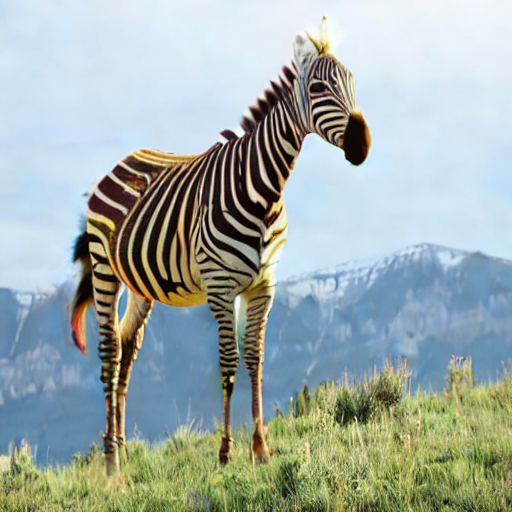

In [20]:
image_name = "horse.jpg"
source_prompt = "Photo of a horse"
destination_prompt = "Photo of a zebra"

input_image = Image.open(image_name).resize((512, 512))

res = diff_edit.edit_image(input_image,source_prompt,destination_prompt)
res

Another exampl. Play with the encoding ratio to see how it affects the output, a low encoding ratio (~ 0.2) will keep more of the original original whereas a high one (~ 0.8) will modify more drastically the image (inside the mask of course)

<class 'PIL.Image.Image'>


/tmp/ipykernel_306/543619803.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  st2_latents = self.scheduler.add_noise(encoded_img, noise, timesteps=torch.tensor(self.scheduler.timesteps[start_step:]))


  0%|          | 0/50 [00:00<?, ?it/s]

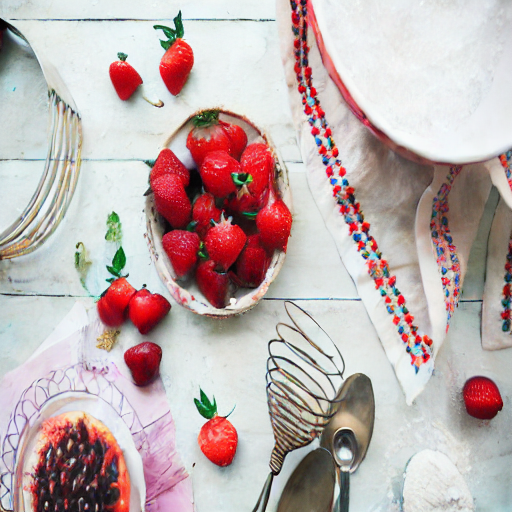

In [26]:
image_name = "fruits.jpg"
source_prompt = "Cherrys on a table"
destination_prompt = "Strawberrys on a table"

input_image = Image.open(image_name).resize((512, 512))

res = diff_edit.edit_image(input_image,source_prompt,destination_prompt,encoding_ratio = 0.4)
res